In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import scipy.stats as st

## 0. 探索数据

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
x1    1000 non-null float64
x2    1000 non-null float64
x3    1000 non-null float64
y     1000 non-null float64
dtypes: float64(4)
memory usage: 31.3 KB


探索数据集的特征

In [5]:
sns.set(style='whitegrid', context='notebook')

/home/scott/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


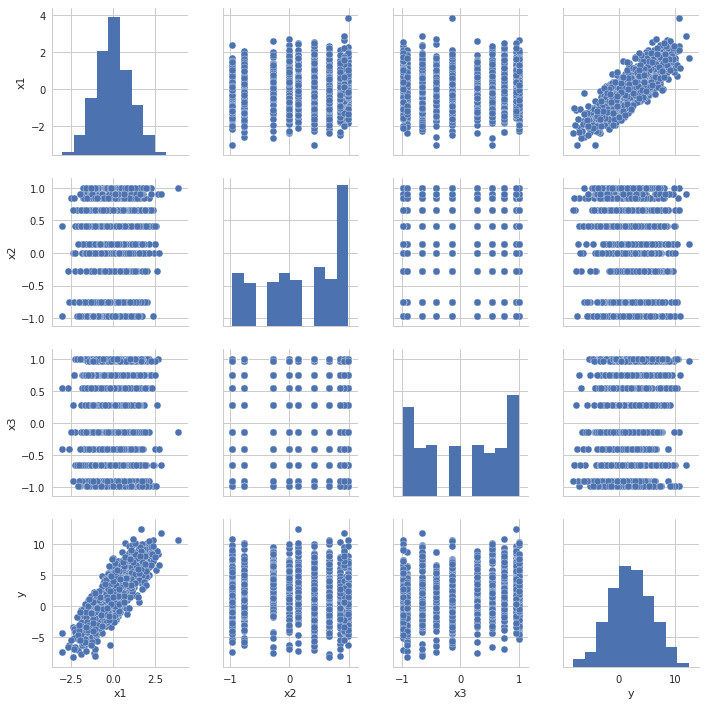

In [6]:
sns.pairplot(df, size=2.5);

/home/scott/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


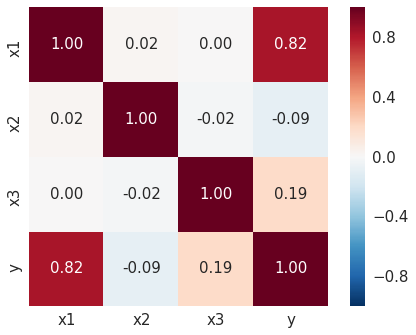

In [7]:
cols = df.columns.tolist()
cm = np.corrcoef(df.values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

# plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)
plt.show()

从上图也能看出，只有 x1 和 y 有较强的相关性，所以解决这个回归问题有两种方案。

## 1. 构建模型

**Hypothesis:**

$$ h(x) = w{^T}x$$

find lines/hyperplaances with small residuals.(2d/3d)

$$w = (X^TX)^{-1}X^Ty$$

compute sse, se

$$SSE = \sum(y_i - \hat{y})^2$$
$$s^2 = MSE = \frac{SSE}{n - p - 1}$$
$$s = \sqrt{MSE} = \sqrt{\frac{SSE}{n - p - 1}}$$
$$sb_i = \frac{s}{\sqrt{\sum(x_i - \bar{x})^2}}$$

$$t = \frac{\left|\hat{\beta} - 0\right|}{\sqrt{sb_i}}$$

### 1.1 最小二乘法

In [8]:
def compute_p(X, y, w_, predict):
    df_ = X.shape[0] - X.shape[1]  # Degree of freedom
    sse = np.sum((predict - y) ** 2, axis=0)
    mse = sse / df_
    c = mse * np.linalg.inv(X.T.dot(X))
    se = np.sqrt(np.diag(c))  # 取对角线的元素
    t = w_ / se
    p_ = 2 * (1 - st.t.cdf(np.abs(t), df_))
    return t, p_

In [9]:
class LinearRegressionLS(object):
    def fit(self, X, y):
        self.w_ = np.linalg.lstsq(X, y)[0]
        self.t, self.p_ = compute_p(X, y, self.w_, self.predict(X))
        return self
    
    def net_input(self, X):
        return np.dot(X[:, 1:], self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)  

**考虑普通线性回归的情况：**

* 主要自变量为 x1

In [10]:
X = df.iloc[:, :3].values
X = np.c_[np.ones(X.shape[0]).T, X]  # 添加一个截距项在左边
y = df.iloc[:, 3].values

In [11]:
ls = LinearRegressionLS()
ls.fit(X, y)
ls.w_

array([ 2.03076198,  2.97396653, -0.54139002,  0.97132913])

In [12]:
ls.p_

array([  0.00000000e+00,   0.00000000e+00,   1.17984007e-08,
         0.00000000e+00])

画图看看拟合效果

In [13]:
test_times = pd.read_csv('times.csv')

In [14]:
test_times

,Miles,Deliveries,Times
0,100,4,9.3
1,50,3,4.8
2,100,4,8.9
3,100,2,6.5
4,50,2,4.2
5,80,2,6.2
6,75,3,7.4
7,65,4,6.0
8,90,3,7.6
9,90,2,6.1


In [15]:
X = test_times.iloc[:, :2].values
X = np.c_[np.ones(X.shape[0]).T, X]  # 添加一个截距项在左边
y = test_times.iloc[:, 2].values

### 1.2 牛顿法

参考 PRML 4.3.3 节


$w^{(new)} = w^{(old)} - H^{-1}\bigtriangledown E(w) \tag{1.2.1}$

$\bigtriangledown E(w) = \sum_{n=1}^{N}(w^T\phi_n - t_n)\phi_n = \Phi^T\Phi w - \Phi^Tt \tag{1.2.2}$

$H = \bigtriangledown \bigtriangledown E(w) = \sum_{n=1}^{N}\phi_n\phi_n^T = \Phi^T\Phi \tag{1.2.3}$

\begin{align}
w^{(new)} &= w^{(old)} - (\Phi^T\Phi)^{-1}\{\Phi^T\Phi w^{(old)} -\Phi^Tt \} \\
&= (\Phi^T\Phi)^{-1}\Phi^Tt \tag{1.2.4}
\end{align}

从上面公式可以看出，w 迭代一次就会变成最小二乘解

In [16]:
import numpy as np

In [17]:
class LinearRegressionNR(object):
    """Newton-Raphoson Method."""
    def __init__(self, w_=[0, 0, 0]):
        self.w_ = w_
        
    def fit(self, X, y):
        # Iterate one step 
        self.w_ = self.w_ - np.linalg.inv(X.T.dot(X)).dot(
            X.T.dot(X).dot(self.w_) - X.T.dot(y))
        self.t, self.p_ = compute_p(X, y, self.w_, self.predict(X))
        return self
    
    def net_input(self, X):
        return np.dot(X[:, 1:], self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X) 

In [18]:
nr = LinearRegressionNR()

初始的 w_ 值

In [19]:
nr.w_

[0, 0, 0]

迭代一次，拟合之后

In [20]:
nr.fit(X, y)
nr.w_

array([-0.86870147,  0.0611346 ,  0.92342537])

In [21]:
np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

array([-0.86870147,  0.0611346 ,  0.92342537])

In [22]:
ls.w_

array([ 2.03076198,  2.97396653, -0.54139002,  0.97132913])

In [23]:
nr.fit(X, y)

In [24]:
nr.w_

array([-0.86870147,  0.0611346 ,  0.92342537])

### 1.3 随机梯度下降法

$$err(\hat{y}, y) = (\hat{y} -y)^2$$

\begin{align}
E_{in}(w) &= \frac{1}{N}\sum_{x=1}^N(w^Tx_{n} - y_{n})^2 \\ 
&= \frac{1}{N}\sum_{x=1}^N(x_{n}^Tw - y_{n})^2 \\
&= \frac{1}{N}
\begin{Vmatrix}
x^T_1w - y_1\\
x^T_2w - y_2\\
...\\
x^T_Nw - y_N
\end{Vmatrix}^2 \\
& = \frac{1}{N}\begin{Vmatrix}Xw - Y\end{Vmatrix}^2
\end{align}

In [57]:
class LinearRegressionSGD(object):
    """Linear Regression.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    cost_ : list
        Sum-of-squares cost function value averaged over all
        training samples in each epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            np.random.seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        self.t, self.p_ = compute_p(X, y, self.w_, self.predict(X))
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to zeros"""
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(self, X)

In [58]:
sgd = LinearRegressionSGD(n_iter=15, eta=0.01, random_state=42)

In [59]:
X = df.iloc[:, :3].values
y = df.iloc[:, 3].values

In [60]:
sgd.fit(X, y)
sgd.w_

TypeError: net_input() takes 2 positional arguments but 3 were given

In [52]:
sgd.cost_

[2.2948359275842689,
 1.9363849020929147,
 1.9266239612428337,
 1.9274290834534786,
 1.9272601525159456,
 1.9354518909254299,
 1.9369892657599503,
 1.9374456223217562,
 1.9343635788284617,
 1.9212550680188529,
 1.9362110158731705,
 1.9398331678158587,
 1.9345545865661107,
 1.9341039214781384,
 1.9373954829761597]

/home/scott/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


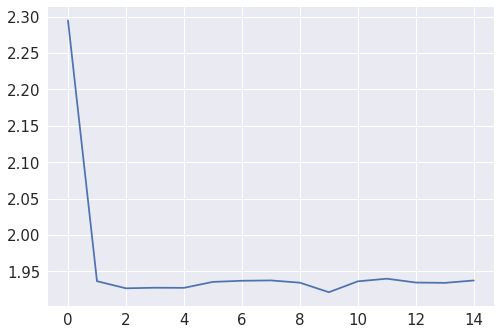

In [53]:
plt.plot(range(len(sgd.cost_)), sgd.cost_)
plt.show()